Name :

E-mail :

### Module Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers, regularizers
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Useful Jupyter Notebook Shortcuts

Here are some helpful keyboard shortcuts for Jupyter Notebook:

- **M**: Switch to Markdown mode
- **Y**: Switch to Code mode
- **A**: Insert cell above
- **B**: Insert cell below
- **D, D**: (Press D twice) Delete selected cell
- **Shift + Enter**: Run the current cell and move to the next
- **Ctrl + Enter**: Run the current cell and stay on it
- **Shift + Tab**: Show function/method documentation
- **Ctrl + Shift + -**: Split cell at cursor
- **Esc**: Enter command mode (blue border)
- **Enter**: Enter edit mode (green border)


## Make a table in markdown :

```
| Architecture | Scaled | Epochs | mse  | val_mse | $R^2$ |
|--------------|--------|--------|------|---------|-------|
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
```

Note: The number of spaces used in this markdown table is just for visual formatting and is not mandatory. The table will render correctly even with minimal spacing.

will generate :
| Architecture | Scaled | Epochs | mse  | val_mse | $R^2$ |
|--------------|--------|--------|------|---------|-------|
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |

### Local Functions

In [6]:
def read_fixed_width_file(file_path: str, skip_lines: int = 0) -> tuple[pd.DataFrame, dict[str, str]]:
    """
    Read a fixed-width file into a pandas DataFrame and return associated units.

    This function reads a specific fixed-width file format containing information about
    red giant stars. It creates a pandas DataFrame from the file contents and provides
    a dictionary of units for each column.

    :param file_path: Path to the fixed-width file.
    :type file_path: str
    :param skip_lines: Number of lines to skip at the beginning of the file, defaults to 0.
    :type skip_lines: int, optional

    :return: A tuple containing the pandas DataFrame and a dictionary of units.
    :rtype: Tuple[pd.DataFrame, Dict[str, str]]

    :raises FileNotFoundError: If the specified file_path does not exist.
    :raises pd.errors.EmptyDataError: If the file is empty.

    .. note::
        The file is expected to have the following columns:
        Type, 2MASS, Teff, log(g), [Fe/H], [a/Fe], lnM, lnAge, chi2, GALR,
        e_Teff, e_log(g), e_[Fe/H], e_[a/Fe], e_logM, e_logAge

    .. warning::
        This function is designed for a specific file format. Using it with different
        file formats may lead to unexpected results.

    Example:
        >>> file_path = 'path/to/your/apj523069t1_mrt.txt'
        >>> df, units = read_fixed_width_file(file_path, skip_lines=5)
        >>> print(df.head())
        >>> print(units)
    """
    # Define the column specifications
    col_specs = [
        (0, 8), (9, 16), (17, 21), (22, 26), (27, 33), (34, 39),
        (40, 44), (45, 49), (50, 55),
    ]

    # Define the column names
    col_names = [
        'RAdeg', 'Dedeg', 'Teff', 'log(g)', '[Fe/H]', '[a/Fe]',
        'mass_in', 'mass', 'age'
    ]

    # Define the units for each column
    units = {
        'Teff': 'K',
        'log(g)': '[cm/s2]',
        '[Fe/H]': '[Sun]',
        '[a/Fe]': '[Sun]',
        'mass_in': '[sol. Mass]',
        'mass': '[sol. Mass]',
        'age': '[Gyr]',
    }

    # Read the file using read_fwf function
    df = pd.read_fwf(file_path,
                     colspecs=col_specs,
                     names=col_names,
                     encoding='utf-8',
                     skiprows=skip_lines)

    return df, units


In [7]:
def scaled_train_test_split(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Scale the training and test DataFrames using StandardScaler.

    This function applies StandardScaler to the input DataFrames, fitting the scaler
    on the training data and then transforming both training and test data.

    Parameters
    ----------
    df_train : pd.DataFrame
        The training DataFrame to be scaled.
    df_test : pd.DataFrame
        The test DataFrame to be scaled.

    Returns
    -------
    tuple[pd.DataFrame, pd.DataFrame]
        A tuple containing the scaled training DataFrame and the scaled test DataFrame.

    Raises
    ------
    ValueError
        If df_train and df_test do not have the same columns.
    AssertionError
        If either df_train or df_test is empty.

    Examples
    --------
    >>> train_df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
    >>> test_df = pd.DataFrame({'A': [7, 8], 'B': [9, 10]})
    >>> scaled_train, scaled_test = scaled_train_test(train_df, test_df)
    """
    assert not df_train.empty, "Training DataFrame is empty"
    assert not df_test.empty, "Test DataFrame is empty"

    if not df_train.columns.equals(df_test.columns):
        raise ValueError("Training and test DataFrames must have the same columns")

    scaler = StandardScaler()
    scaled_df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
    scaled_df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

    return scaled_df_train, scaled_df_test

### global variables

In [8]:
DATASET_URL = "https://content.cld.iop.org/journals/0067-0049/249/1/7/revision1/apjsab8bcdt8_mrt.txt"
RANDOM_SEED = 42

# Dataset Preparation

## downloading data

In [10]:
import pandas as pd

df_planets, units = read_fixed_width_file(DATASET_URL,20)
#Afficher les deux premières lignes du DataFrame pour vérifier les données
print(df_planets.head())
#Afficher les informations à propos du DataFrame
print(units)

      RAdeg   Dedeg  Teff  log(g)  [Fe/H]  [a/Fe]  mass_in  mass   age
0  323.9122  7.4972  4085    1.39  -0.002    0.02     1.59  1.58  2.94
1  323.9490  0.5533  4685    2.84   0.070    0.16     1.02  1.07  9.07
2  324.0119  5.5206  4493    1.72  -0.431    0.02     1.27  1.47  1.92
3  324.0126  0.8406  4687    2.55   0.041    0.04     2.18  1.49  4.82
4  324.0231  3.7678  4622    2.66   0.236    0.06     1.31  1.41  4.11
{'Teff': 'K', 'log(g)': '[cm/s2]', '[Fe/H]': '[Sun]', '[a/Fe]': '[Sun]', 'mass_in': '[sol. Mass]', 'mass': '[sol. Mass]', 'age': '[Gyr]'}


On affiche les unitées du dataframe ainsi que les premières lignes afin de voir le forme du fichier, ici :
```
{'Teff': 'K', 'log(g)': '[cm/s2]', '[Fe/H]': '[Sun]', '[a/Fe]': '[Sun]', 'mass_in': '[sol. Mass]', 'mass': '[sol. Mass]', 'age': '[Gyr]'}
```

## Data Analysis

In [ ]:
#def histogram_intersection(a, b):
#    v = np.minimum(a, b).sum().round(decimals=1)
#    return v
#df = pd.DataFrame([(.2, .3), (.0, .6), (.6, .0), (.2, .1)],
#                  columns=['dogs', 'cats'])
#df.corr(method=histogram_intersection)

In [12]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v
df = df_planets
df.corr(method=histogram_intersection)

,RAdeg,Dedeg,Teff,log(g),[Fe/H],[a/Fe],mass_in,mass,age
RAdeg,1.0,231994.1,12745156.5,178218.8,-10741.6,6903.8,102003.6,96454.6,355444.2
Dedeg,231994.1,1.0,236490.6,65151.0,-73482.3,-58919.9,13712.6,10243.3,131792.3
Teff,12745156.5,236490.6,1.0,179001.8,-10740.6,6904.3,102283.6,96716.2,358549.3
log(g),178218.8,65151.0,179001.8,1.0,-10740.6,6904.3,100202.7,96679.4,169031.4
[Fe/H],-10741.6,-73482.3,-10740.6,-10740.6,1.0,-12625.1,-10740.6,-10740.6,-10740.6
[a/Fe],6903.8,-58919.9,6904.3,6904.3,-12625.1,1.0,6904.3,6904.3,6904.3
mass_in,102003.6,13712.6,102283.6,100202.7,-10740.6,6904.3,1.0,89356.0,96102.4
mass,96454.6,10243.3,96716.2,96679.4,-10740.6,6904.3,89356.0,1.0,94486.3
age,355444.2,131792.3,358549.3,169031.4,-10740.6,6904.3,96102.4,94486.3,1.0


In [15]:
# Etalement des valeurs
print("\nRanges of each feature")
print(df.describe)


Ranges of each feature
<bound method NDFrame.describe of           RAdeg   Dedeg  Teff  log(g)  [Fe/H]  [a/Fe]  mass_in  mass   age
0      323.9122  7.4972  4085    1.39  -0.002    0.02     1.59  1.58  2.94
1      323.9490  0.5533  4685    2.84   0.070    0.16     1.02  1.07  9.07
2      324.0119  5.5206  4493    1.72  -0.431    0.02     1.27  1.47  1.92
3      324.0126  0.8406  4687    2.55   0.041    0.04     2.18  1.49  4.82
4      324.0231  3.7678  4622    2.66   0.236    0.06     1.31  1.41  4.11
...         ...     ...   ...     ...     ...     ...      ...   ...   ...
73175  359.9069  7.9644  4905    2.53  -0.195    0.08     1.10  1.34  3.21
73176  359.9242  2.6319  4773    2.42   0.108    0.03     1.62  1.46  3.10
73177  359.9400  0.4572  4641    2.64  -0.066    0.15     1.09  1.09  7.22
73178  359.9527  2.9717  4628    2.18   0.115    0.02     2.45  1.45  1.31
73179  359.9687  1.1244  4712    2.51   0.141    0.08     1.45  1.25  5.33

[73180 rows x 9 columns]>


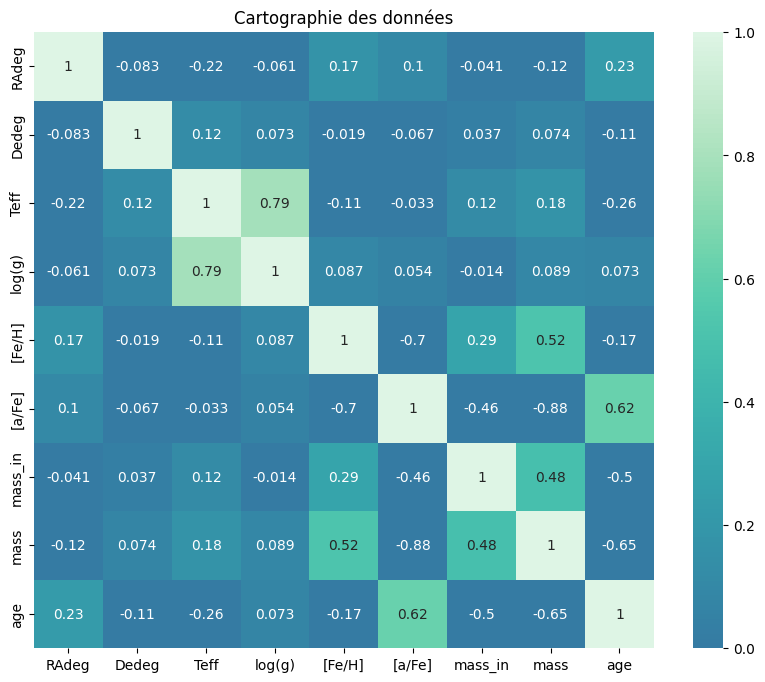

In [41]:
# Import de Seaborn
import seaborn as sns

corr_matrix = df.corr()
plt.figure(figsize=(10,8))
# On cartographie les données en fonction de leurs valeurs
sns.heatmap(corr_matrix, annot=True, cmap='mako', vmin=0, vmax=1, center=0)

plt.title('Cartographie des données')
plt.show()

In [47]:
print(df.dtypes)

RAdeg      float64
Dedeg      float64
Teff         int64
log(g)     float64
[Fe/H]     float64
[a/Fe]     float64
mass_in    float64
mass       float64
age        float64
dtype: object


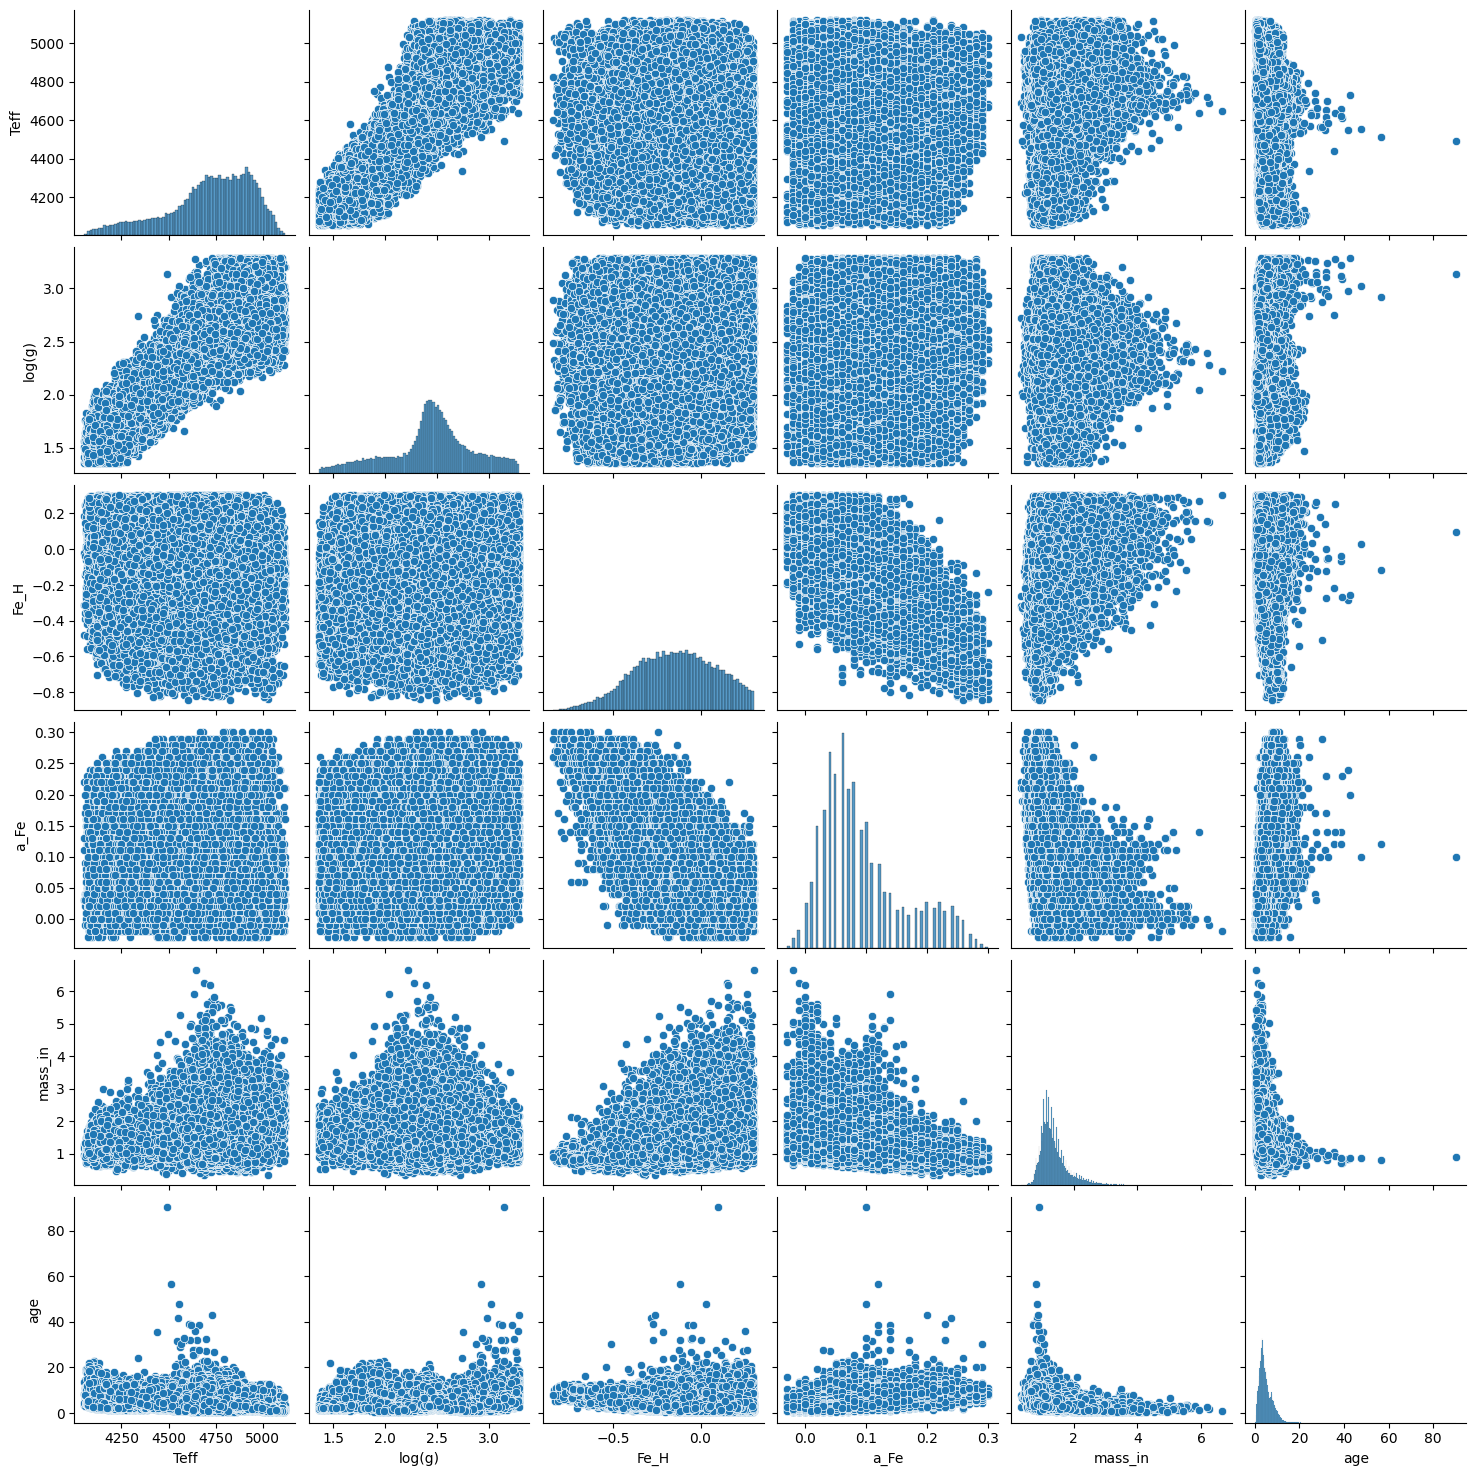

In [46]:
df_renamed = df.rename(columns={'[Fe/H]': 'Fe_H', '[a/Fe]': 'a_Fe'})
training_cols = ['Teff', 'log(g)', 'Fe_H', 'a_Fe', 'mass_in']
output_cols = ['age']

sns.pairplot(df_renamed[training_cols + output_cols])
plt.show()

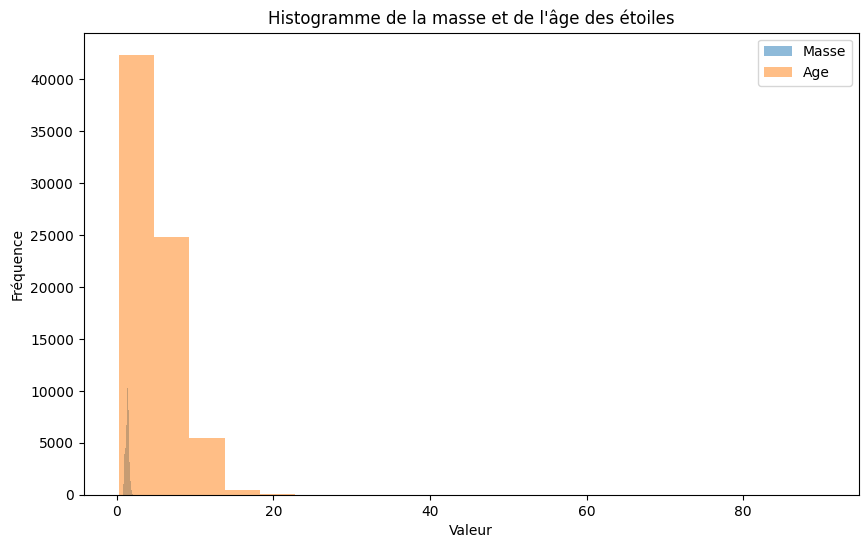

In [21]:
# Histogramme de la masse et de l'âge des étoiles
plt.figure(figsize=(10, 6))
plt.hist(df['mass'], bins=20, alpha=0.5, label='Masse')
plt.hist(df['age'], bins=20, alpha=0.5, label='Age')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.legend()
plt.title('Histogramme de la masse et de l\'âge des étoiles')
plt.show()

La distribution de la masse en fonction de l'âge semble une gaussienne mais ordonnée. Si on trie un peu mieux nos données :

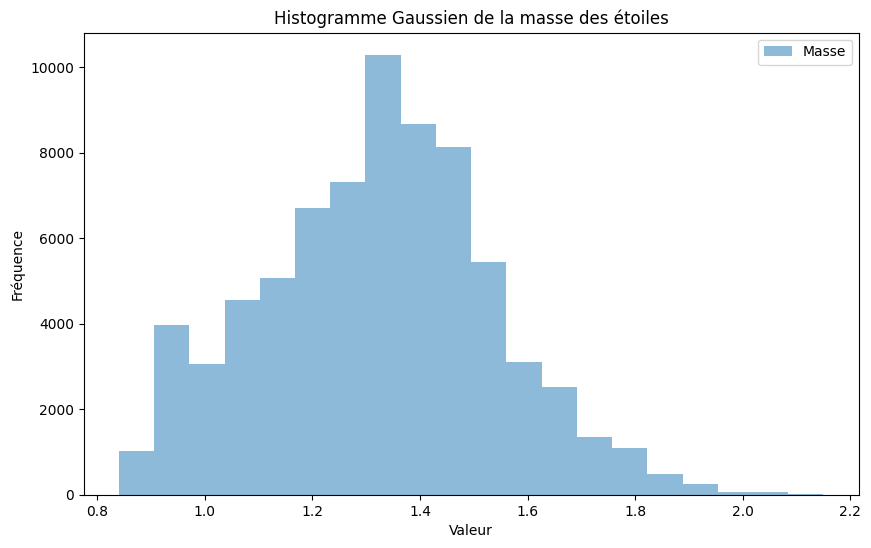

In [24]:
# Histogramme Gaussien de la masse des étoiles
plt.figure(figsize=(10, 6))
plt.hist(df['mass'], bins=20, alpha=0.5, label='Masse')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.legend()
plt.title('Histogramme Gaussien de la masse des étoiles')
plt.show()

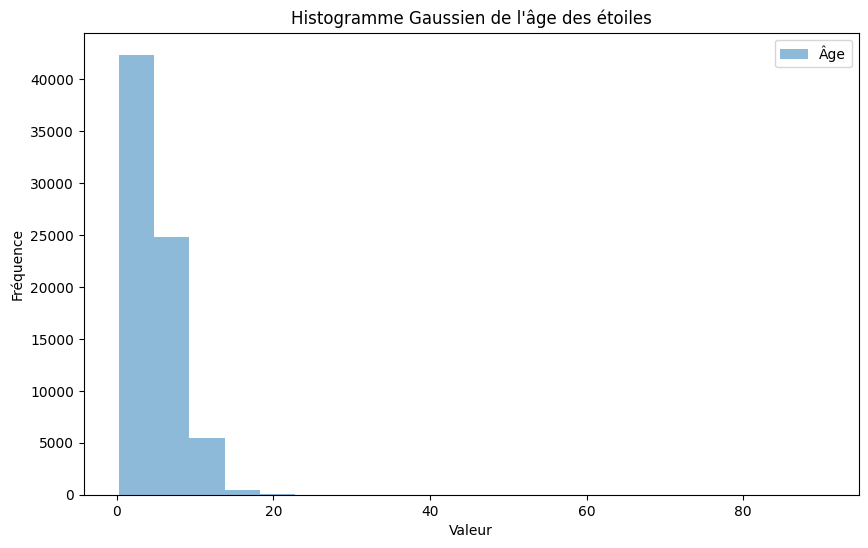

In [25]:
# Histogramme Gaussien de l'âge' des étoiles
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, alpha=0.5, label='Âge')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.legend()
plt.title('Histogramme Gaussien de l\'âge des étoiles')
plt.show()

En raison de la distribution de l'âge des étoiles, on en déduit une distribution centrée autour des étoiles jeunes qui ont généralement moins de masse.

## Data splitting

In [79]:
df_renamed = df.rename(columns={'[Fe/H]': 'Fe_H', '[a/Fe]': 'a_Fe'})
train, test = train_test_split(df_renamed, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [80]:
# On affiche l'histogramme de l\'âge des étoiles et des datasets test
y = df['age']
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

# Simple Perceptron

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def simple_perceptron(train: pd.DataFrame, test: pd.DataFrame,
                      training_cols: list[str], output_cols: list[str]):
  """
  Trains and evaluates a simple linear regression model.

  Args:
    train: Training DataFrame.
    test: Test DataFrame.
    training_cols: List of column names to use for training.
    output_cols: List of column names to use for the output (target).

  Returns:
    A tuple containing the R-squared score and the Mean Squared Error on the test set.
  """
  perceptron = LinearRegression()
  X_train = train[training_cols]
  y_train = train[output_cols]
  X_test = test[training_cols]
  y_test = test[output_cols]

  # Entraîne the modèle sans compilation
  perceptron.fit(X_train, y_train)

  # Réalise les predictions
  y_pred = perceptron.predict(X_test)

  # Evalue le model
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  return r2, mse

In [84]:
# Example
r2, mse = simple_perceptron(train, test, training_cols, output_cols)
print(f"R^2: {r2:.4f}") # Score R^2 qui détermine la corrélation entre le modèle prédictif et le modèle test
print(f"Erreur quadratique moyenne: {mse:.4f}") # Erreur quadratique (MSE) avec 4 chiffres significatifs

R^2: 0.6527
Erreur quadratique moyenne: 2.6828


## Initial Model Architecture

In [83]:
from keras.models import Sequential
from keras.layers import Dense

def keras_model(input_shape):
  model = Sequential()
  model.add(Input(input_shape, name='input'))
  model.add(Dense(1, name='output'))
  return model

## Compile and Training

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Crée une instance de modèle Keras
input_shape = (len(training_cols),)
model = keras_model(input_shape)

model.compile(optimizer='adamW', loss='mse', metrics=["mse", "mae"])

On tente ici d'utiliser la méthode `compile` sur un objet `LinearRegression` issu de notre ancienne fonction `Simple Perceptron`, qui n'est pas un modèle Keras. La méthode `compile` sert à configurer les modèles Keras pour l'entraînement d'où l'apparition d'une erreur.

On a défini une fonction `keras_model` pour créer un modèle Keras, mais nous ne l'avons pas appelée pour créer une instance de modèle que nous pouvons ensuite compiler.

Ainsi, il est nécessaire d'ajouter une ligne avant l'étape de compilation afin de créer un modèle Keras à l'aide de notre fonction `keras_model` et de déterminer la forme d'entrée appropriée à partir de vos données d'entraînement.

In [91]:
X_train = train[training_cols]
y_train = train[output_cols]
X_test = test[training_cols]
y_test = test[output_cols]

history = model.fit(X_train, y_train, verbose=2, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1830/1830 - 5s - 3ms/step - loss: 2849307.5000 - mae: 1244.6517 - mse: 2849307.5000 - val_loss: 2220.9292 - val_mae: 46.9560 - val_mse: 2220.9292
Epoch 2/10
1830/1830 - 3s - 2ms/step - loss: 143.5041 - mae: 6.8124 - mse: 143.5041 - val_loss: 7.6719 - val_mae: 2.1860 - val_mse: 7.6719
Epoch 3/10
1830/1830 - 3s - 2ms/step - loss: 8.1593 - mae: 2.2108 - mse: 8.1593 - val_loss: 7.6649 - val_mae: 2.1805 - val_mse: 7.6649
Epoch 4/10
1830/1830 - 5s - 3ms/step - loss: 8.1571 - mae: 2.2102 - mse: 8.1571 - val_loss: 7.6533 - val_mae: 2.1754 - val_mse: 7.6533
Epoch 5/10
1830/1830 - 4s - 2ms/step - loss: 8.1482 - mae: 2.2079 - mse: 8.1482 - val_loss: 7.6328 - val_mae: 2.1518 - val_mse: 7.6328
Epoch 6/10
1830/1830 - 3s - 2ms/step - loss: 8.1305 - mae: 2.2045 - mse: 8.1305 - val_loss: 7.7423 - val_mae: 2.1050 - val_mse: 7.7423
Epoch 7/10
1830/1830 - 4s - 2ms/step - loss: 8.0694 - mae: 2.1921 - mse: 8.0694 - val_loss: 7.4326 - val_mae: 2.1075 - val_mse: 7.4326
Epoch 8/10
1830/1830 - 4s - 2

On remarque qu'avec `AdamW`, la perte diminue drastiquement après seulement deux entraînements et semble converger vers $7$.

## Model Performance

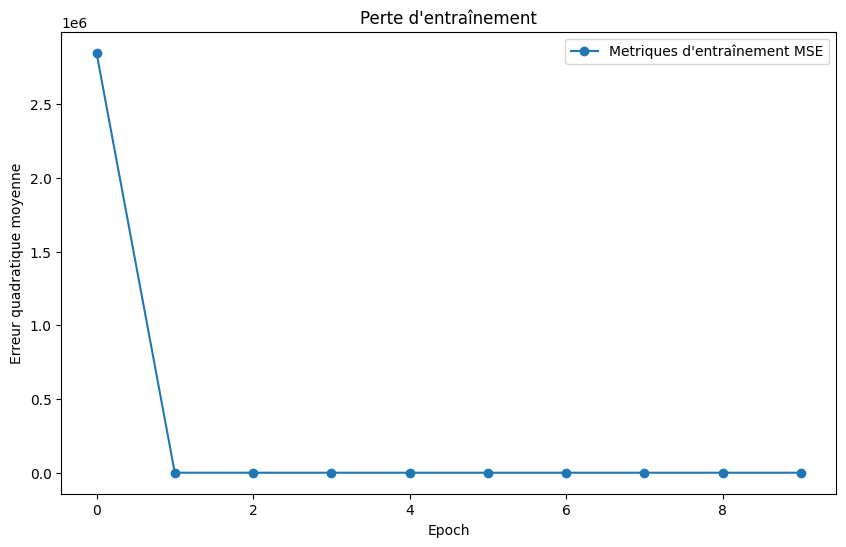

In [96]:
# Plot de l'historique d'entraînement
plt.figure(figsize=(10, 6))
#plt.plot(history.history['loss'], "o-", label='Perte d\'entraînement')
plt.plot(history.history['mse'], "o-", label='Metriques d\'entraînement MSE')
plt.title('Perte d\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Erreur quadratique moyenne')
plt.legend()
plt.show()

### Loss and MSE

La moyenne des valeurs absolues des résidus, sur la base de test semble similaire à l'erreur quadratique moyenne définie tel que :

\begin{align*}
{\displaystyle \operatorname {MSE} ({\hat {\theta }})\,{\overset {\text{def}}{=}}\,\mathbb {E} \left[({\hat {\theta }}-\theta )^{2}\right]}
\end{align*}

**sources** :
- Wikipédia : https://fr.wikipedia.org/wiki/Erreur_quadratique_moyenne

### $R^2$ Score

En statistique, le coefficient de détermination linéaire de Pearson, noté ${\displaystyle R^{2}}$ ou ${\displaystyle r^{2}}$, est une mesure de la qualité de la prédiction d'une régression linéaire. Il est défini tel que :

\begin{align*}
{\displaystyle R^{2}=1-{\dfrac {\sum _{i=1}^{n}\left(y_{i}-{\hat {y_{i}}}\right)^{2}}{\sum _{i=1}^{n}\left(y_{i}-{\bar {y}}\right)^{2}}}}
\end{align*}

où ${\displaystyle n}$ est le nombre de mesures, ${\displaystyle y_{i}}$ la valeur de la $i$-ème mesure , ${\displaystyle {\hat {y_{i}}}}$ la valeur prédite correspondante et ${\displaystyle {\bar {y}}}$ la moyenne des mesures.

**sources** :
- Wikipédia : https://fr.wikipedia.org/wiki/Coefficient_de_d%C3%A9termination

In [102]:
# Exemple
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f"score R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")

score R^2: 0.9486
MSE: 0.3750


Comme vu dans cet exemple, la valeur de $R^2$ est proche de $1$ ce qui signifie que les valeurs prédites ${\displaystyle {\hat {y}}}$ sont proches des valeurs moyennes ${\displaystyle {\bar {y}}}$.

# Multilayer Perceptron

458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


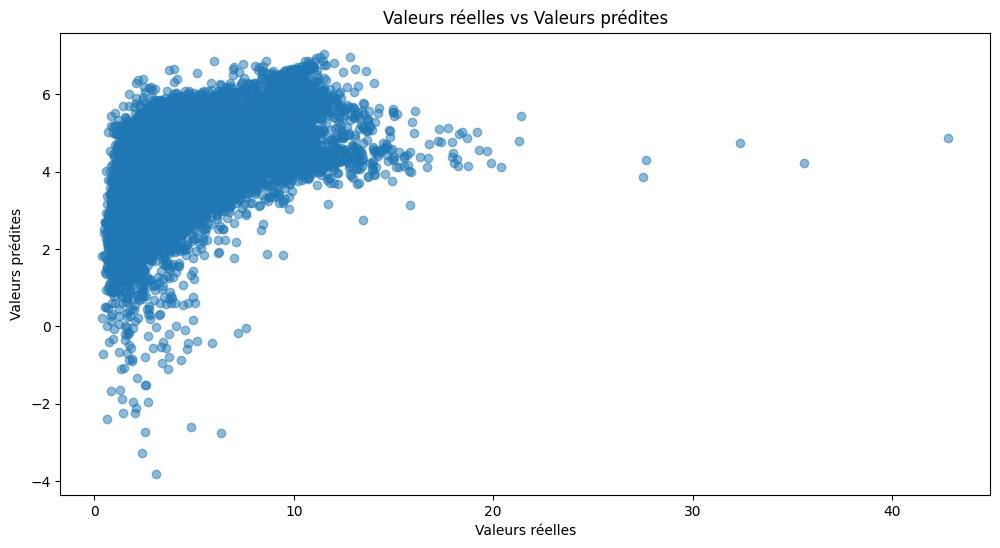

In [104]:
# Generate predictions
y_pred = model.predict(X_test)

# Scatter plot of actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Valeurs réelles vs Valeurs prédites')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.show()

D'après la figure numérique d'éparpillement des valeurs,

## Initial MLP

In [ ]:
# Test

## Optimization

### Data scaling

### Helpfull layers

### Regularization

### Epochs

# Conclusion